In [3]:
from __future__ import print_function
import os
import time
import h5py as h5
import numpy as np
import sklearn
import tensorflow as tf
from tensorflow import keras
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

print ("Numpy      ver. ", np.__version__)
print ("H5Py       ver. ", h5.__version__)
print ("SKLearn    ver. ", sklearn.__version__)
print ("TensorFlow ver. ", tf.__version__)
print ("Keras      ver. ", keras.__version__)

#os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

#np.random.seed(777)
#tf.set_random_seed(777)

import matplotlib
#matplotlib.use('agg')             ## Need for CMD
import matplotlib.pyplot as plt
%matplotlib inline


Numpy      ver.  1.17.4
H5Py       ver.  2.9.0
SKLearn    ver.  0.21.3
TensorFlow ver.  1.15.0
Keras      ver.  2.2.4-tf


In [4]:
###
###  Construct TF graph
###

#ROOT_FOLDER = './model'
ROOT_FOLDER = '/tmp/tf_model'
ROOT_FOLDER = '/home/p00lcy01/TWCC_con/save/kcnn3_tanh'
ROOT_FOLDER = '/home/p00lcy01/TWCC_con/save/kcnn3_relu'
ROOT_FOLDER = '/home/p00lcy01/TWCC_con/save/kcnn3_elu'
ROOT_FOLDER = '/home/p00lcy01/TWCC_con/save/kcnn3_tanh_v2'

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

tf.reset_default_graph()
RATE = 8192
DIM   = RATE
LRATE        = 1e-5   ##-4
#keep_prob = tf.placeholder(tf.float32)   ##  for dropout, not used.
#lrate     = tf.placeholder(tf.float32)
#bs        = tf.placeholder(tf.int64)     ##  use dynamics batch_size to account for train/test stage both

##########################################
##import GWDA.model
###########################################
F = [16,32,64]
K = [16, 8, 8]
D = [ 1, 1, 1]
S = [ 1, 1, 1]
PO= [ 4, 4, 4]
PS= [ 4, 4, 4]
args0 = { "padding":'valid', "data_format":"channels_last" }
act=tf.nn.relu
act=tf.nn.elu
act=tf.nn.tanh

ki  = keras.initializers.TruncatedNormal() ##(seed=2)
ki0 = keras.initializers.Zeros()
input_data = keras.layers.Input(shape=(RATE,1))
a1=keras.layers.Conv1D(F[0], K[0], S[0], name="conv1", dilation_rate=D[0], kernel_initializer=ki, bias_initializer=ki0, activation=act, **args0)(input_data)
a1=keras.layers.MaxPooling1D(PO[0], PS[0], name="mp1", **args0)(a1)
a1=keras.layers.Conv1D(F[1], K[1], S[1], name="conv2", dilation_rate=D[1], kernel_initializer=ki, bias_initializer=ki0, activation=act, **args0)(a1)
a1=keras.layers.MaxPooling1D(PO[1], PS[1], name="mp2", **args0)(a1)
a1=keras.layers.Conv1D(F[2], K[2], S[2], name="conv3", dilation_rate=D[2], kernel_initializer=ki, bias_initializer=ki0, activation=act, **args0)(a1)
a1=keras.layers.MaxPooling1D(PO[2], PS[2], name="mp3", **args0)(a1)
a1=keras.layers.Flatten()(a1)
a2=keras.layers.Dense(64, kernel_initializer=ki, bias_initializer=ki0, activation=act, name='fc1')(a1)
a2=keras.layers.Dense(1, activation=tf.nn.sigmoid, name='logit')(a2)
model = keras.models.Model(input_data, a2)

model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True), optimizer=keras.optimizers.Adam(lr=LRATE), 
              metrics=['accuracy', 
                       keras.metrics.Recall(), 
                       keras.metrics.TruePositives(name='tp'),
                       keras.metrics.FalsePositives(name='fp'),
                       keras.metrics.TrueNegatives(name='tn'),
                       keras.metrics.FalseNegatives(name='fn'),
                       keras.metrics.AUC(num_thresholds=64, name='roc', curve='ROC'),
                       keras.metrics.AUC(num_thresholds=64, name='pr', curve='PR')
                                          ])

model.summary()
print(model.metrics_names)
# Compute predictions
#predict_prob = tf.sigmoid(logits, name="sigmoid_tensor")
#predict_op   = tf.cast( tf.round(predict_prob), tf.int32 )
#loss_op = tf.losses.sigmoid_cross_entropy(logits=logits, multi_class_labels=y)
#with tf.name_scope('optimizer'):
#    optimizer = tf.train.AdamOptimizer(LRATE).minimize(loss_op)

#model.fit(x_train, y_train, batch_size=128 * 2, epochs=2, verbose=1, validation_data=(x_test, y_test))


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8192, 1)]         0         
_________________________________________________________________
conv1 (Conv1D)               (None, 8177, 16)          272       
_________________________________________________________________
mp1 (MaxPooling1D)           (None, 2044, 16)          0         
_________________________________________________________________
conv2 (Conv1D)               (None, 2037, 32)          4128      
_________________________________________________________________
mp2 (MaxPooling1D)           (No

In [ ]:
def visualize_conv_layer(layer_name):
  layer_output=model.get_layer(layer_name).output
  intermediate_model=tf.keras.models.Model(inputs=model.input,outputs=layer_output)
  intermediate_prediction=intermediate_model.predict(x_train[2].reshape(1,28,28,1))
  
  row_size=4
  col_size=8
  
  img_index=0
 
  print(np.shape(intermediate_prediction))
  
  fig,ax=plt.subplots(row_size,col_size,figsize=(10,8))
 
  for row in range(0,row_size):
    for col in range(0,col_size):
      ax[row][col].imshow(intermediate_prediction[0, :, :, img_index], cmap='gray')
 
      img_index=img_index+1
    
visualize_conv_layer('conv1')


Sampling rate :  8192
== Load :  /home/p00lcy01/TWCC_con/save/kcnn3_tanh_v2/model_1.80.h5
 A= 1.40 : a/s:   0.999   0.996, TP/FP/TN/FN:   516     0  1051     2 roc/pr:   0.999   0.999 speed:  1847 wf/s
 A= 1.36 : a/s:   0.998   0.994, TP/FP/TN/FN:   515     0  1051     3 roc/pr:   0.999   0.999 speed:  3734 wf/s
 A= 1.31 : a/s:   0.995   0.985, TP/FP/TN/FN:   510     0  1051     8 roc/pr:   0.999   0.999 speed: 21379 wf/s
 A= 1.27 : a/s:   0.993   0.979, TP/FP/TN/FN:   507     0  1051    11 roc/pr:   0.998   0.998 speed: 22683 wf/s
 A= 1.22 : a/s:   0.981   0.942, TP/FP/TN/FN:   488     0  1051    30 roc/pr:   0.990   0.991 speed: 25780 wf/s
 A= 1.18 : a/s:   0.962   0.886, TP/FP/TN/FN:   459     0  1051    59 roc/pr:   0.981   0.982 speed: 23991 wf/s
 A= 1.13 : a/s:   0.950   0.847, TP/FP/TN/FN:   439     0  1051    79 roc/pr:   0.963   0.966 speed: 27456 wf/s
 A= 1.09 : a/s:   0.925   0.772, TP/FP/TN/FN:   400     0  1051   118 roc/pr:   0.940   0.944 speed: 19540 wf/s
 A= 1.04 : a/s

 A= 1.04 : a/s:   0.992   0.977, TP/FP/TN/FN:   506     0  1051    12 roc/pr:   0.997   0.997 speed: 31728 wf/s
 A= 1.00 : a/s:   0.987   0.959, TP/FP/TN/FN:   497     0  1051    21 roc/pr:   0.995   0.996 speed: 28444 wf/s
 A= 0.95 : a/s:   0.978   0.934, TP/FP/TN/FN:   484     0  1051    34 roc/pr:   0.983   0.984 speed: 29280 wf/s
 A= 0.91 : a/s:   0.957   0.869, TP/FP/TN/FN:   450     0  1051    68 roc/pr:   0.970   0.972 speed: 31057 wf/s
 A= 0.86 : a/s:   0.922   0.763, TP/FP/TN/FN:   395     0  1051   123 roc/pr:   0.947   0.951 speed: 23336 wf/s
 A= 0.82 : a/s:   0.890   0.668, TP/FP/TN/FN:   346     0  1051   172 roc/pr:   0.886   0.891 speed: 27296 wf/s
 A= 0.77 : a/s:   0.835   0.500, TP/FP/TN/FN:   259     0  1051   259 roc/pr:   0.820   0.822 speed: 28355 wf/s
 A= 0.73 : a/s:   0.781   0.338, TP/FP/TN/FN:   175     0  1051   343 roc/pr:   0.746   0.737 speed: 23820 wf/s
 A= 0.68 : a/s:   0.748   0.236, TP/FP/TN/FN:   122     0  1051   396 roc/pr:   0.694   0.672 speed: 214

 A= 0.68 : a/s:   0.893   0.676, TP/FP/TN/FN:   350     0  1051   168 roc/pr:   0.895   0.900 speed: 25247 wf/s
 A= 0.64 : a/s:   0.824   0.467, TP/FP/TN/FN:   242     0  1051   276 roc/pr:   0.805   0.805 speed: 22968 wf/s
 A= 0.59 : a/s:   0.787   0.355, TP/FP/TN/FN:   184     0  1051   334 roc/pr:   0.740   0.730 speed: 26722 wf/s
 A= 0.55 : a/s:   0.744   0.224, TP/FP/TN/FN:   116     0  1051   402 roc/pr:   0.672   0.642 speed: 29362 wf/s
 A= 0.50 : a/s:   0.699   0.089, TP/FP/TN/FN:    46     0  1051   472 roc/pr:   0.581   0.505 speed: 21887 wf/s
 A= 0.46 : a/s:   0.686   0.048, TP/FP/TN/FN:    25     0  1051   493 roc/pr:   0.539   0.427 speed: 23488 wf/s
 A= 0.41 : a/s:   0.676   0.017, TP/FP/TN/FN:     9     0  1051   509 roc/pr:   0.519   0.384 speed: 21679 wf/s
 A= 0.37 : a/s:   0.670   0.000, TP/FP/TN/FN:     0     0  1051   518 roc/pr:   0.507   0.352 speed: 23686 wf/s
 A= 0.32 : a/s:   0.670   0.002, TP/FP/TN/FN:     1     0  1051   517 roc/pr:   0.505   0.347 speed: 229

 A= 0.32 : a/s:   0.678   0.025, TP/FP/TN/FN:    13     0  1051   505 roc/pr:   0.518   0.381 speed: 25491 wf/s
 A= 0.28 : a/s:   0.672   0.006, TP/FP/TN/FN:     3     0  1051   515 roc/pr:   0.507   0.352 speed: 26454 wf/s
 A= 0.23 : a/s:   0.670   0.000, TP/FP/TN/FN:     0     0  1051   518 roc/pr:   0.502   0.338 speed: 25264 wf/s
 A= 0.19 : a/s:   0.670   0.000, TP/FP/TN/FN:     0     0  1051   518 roc/pr:   0.500   0.331 speed: 23551 wf/s
 A= 0.14 : a/s:   0.670   0.000, TP/FP/TN/FN:     0     0  1051   518 roc/pr:   0.500   0.330 speed: 22708 wf/s
 A= 0.10 : a/s:   0.670   0.000, TP/FP/TN/FN:     0     0  1051   518 roc/pr:   0.501   0.334 speed: 23897 wf/s
 A= 0.05 : a/s:   0.670   0.000, TP/FP/TN/FN:     0     0  1051   518 roc/pr:   0.500   0.330 speed: 27336 wf/s
 A= 0.01 : a/s:   0.670   0.000, TP/FP/TN/FN:     0     0  1051   518 roc/pr:   0.500   0.330 speed: 26720 wf/s
== Load :  /home/p00lcy01/TWCC_con/save/kcnn3_tanh_v2/model_0.80.h5
 A= 1.40 : a/s:   1.000   1.000, TP/

 A= 1.40 : a/s:   0.999   1.000, TP/FP/TN/FN:   518     1  1050     0 roc/pr:   1.000   0.998 speed: 29549 wf/s
 A= 1.36 : a/s:   0.998   1.000, TP/FP/TN/FN:   518     3  1048     0 roc/pr:   0.999   0.996 speed: 29057 wf/s
 A= 1.31 : a/s:   0.997   1.000, TP/FP/TN/FN:   518     5  1046     0 roc/pr:   1.000   0.998 speed: 27950 wf/s
 A= 1.27 : a/s:   0.996   1.000, TP/FP/TN/FN:   518     6  1045     0 roc/pr:   0.999   0.994 speed: 28932 wf/s
 A= 1.22 : a/s:   0.999   1.000, TP/FP/TN/FN:   518     2  1049     0 roc/pr:   1.000   1.000 speed: 29080 wf/s
 A= 1.18 : a/s:   0.999   1.000, TP/FP/TN/FN:   518     1  1050     0 roc/pr:   1.000   1.000 speed: 28716 wf/s
 A= 1.13 : a/s:   0.999   1.000, TP/FP/TN/FN:   518     2  1049     0 roc/pr:   1.000   0.998 speed: 23713 wf/s
 A= 1.09 : a/s:   1.000   1.000, TP/FP/TN/FN:   518     0  1051     0 roc/pr:   1.000   1.000 speed: 29381 wf/s
 A= 1.04 : a/s:   0.998   1.000, TP/FP/TN/FN:   518     3  1048     0 roc/pr:   0.999   0.996 speed: 277

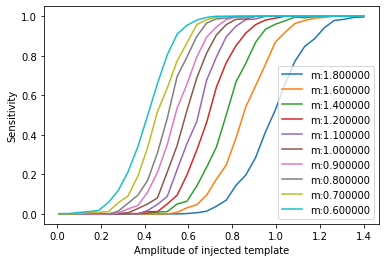

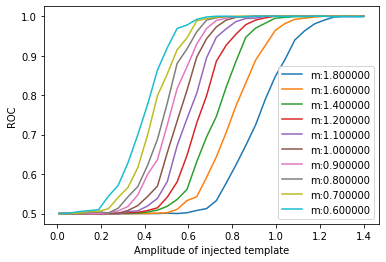

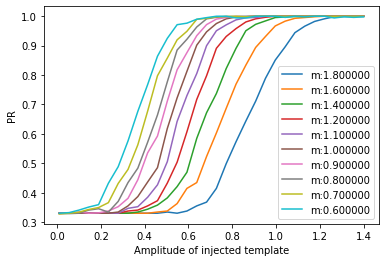

In [6]:
###
###  Testing...
###
import GWDA.loader

NOISE_COPY = 2
H5_FILE="../white_h_8192_dm2.h5"
GWdata = GWDA.loader.GWInject(H5_FILE, plot=0)
RATE   = GWdata.srate
print("Sampling rate : ", RATE)

BATCH = 8192
TRAIN_A =   [1.8, 1.6, 1.4, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5]
TEST_LIST = np.linspace(1.4, 0.01, 32)

with tf.Session() as sess:
    tf.global_variables_initializer().run()

    #fig1 = plt.figure()
    #fig2 = plt.figure()
    
    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()
    fig3, ax3 = plt.subplots()

    
    for m in TRAIN_A:
        CKPT = "%s/model_%4.2f.h5" % (ROOT_FOLDER, m )
        try:
            model.load_weights(CKPT)
            print("== Load : ", CKPT)
        except: 
            print("== Found no file ", CKPT)
            continue
        
        gout=[]
        for amp in TEST_LIST:

            X, Y  = GWdata.get_test_set(A=amp, nc=NOISE_COPY)
            X = np.expand_dims(X, axis=-1)  
            Xts, _, Yts, _ = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=222)

            time0 = time.time()

            #el, ea, er, etp, efp, etn, efn, eroc, epr = model.evaluate(Xts, Yts, verbose=0, batch_size=512)
            eout = model.evaluate(Xts, Yts, verbose=0, batch_size=512)
            
            gout.append(eout)
            print(" A= %4.2f : a/s: %7.3f %7.3f, TP/FP/TN/FN: %5d %5d %5d %5d roc/pr: %7.3f %7.3f speed: %5d wf/s" 
                  % (amp, eout[1], eout[2], eout[3], eout[4], eout[5], eout[6], eout[7], eout[8], len(Yts)/(time.time()-time0) ) )

            ###
            #yprob = model.predict(Xts, verbose=0, batch_size=512)
            #ff = roc_curve(Yts, yprob)
            #print(ff)
            #print(Yts)
        
        gout = np.array(gout)
        ax1.plot(TEST_LIST, gout[:,2], label="m:%f"%m)
        ax2.plot(TEST_LIST, gout[:,7], label="m:%f"%m)
        ax3.plot(TEST_LIST, gout[:,8], label="m:%f"%m)

        with open("%s/his_test.log" % (ROOT_FOLDER), 'a') as f:
            f.write("### A=%4.2f\n" % (amp)  )
            for i in range( len(TEST_LIST) ):
                f.write("%5f %s\n" % ( TEST_LIST[i], " ".join(str(item) for item in gout[i,:])) )
            f.write("\n\n")

    
    FIGNAME = "%s/infer.png" % (ROOT_FOLDER)
    ax1.set_xlabel("Amplitude of injected template")
    ax1.set_ylabel("Sensitivity")
    ax1.legend()
    fig1.savefig(FIGNAME)
    FIGNAME_ROC = "%s/infer_roc.png" % (ROOT_FOLDER)
    ax2.set_xlabel("Amplitude of injected template")
    ax2.set_ylabel("ROC")
    ax2.legend()
    fig2.savefig(FIGNAME_ROC)
    FIGNAME_PR = "%s/infer_pr.png" % (ROOT_FOLDER)
    ax3.set_xlabel("Amplitude of injected template")
    ax3.set_ylabel("PR")
    ax3.legend()
    fig3.savefig(FIGNAME_PR)

In [20]:
a=[1,2,3,4.4,56]
print ("\n".join(str(item) for item in a) )


1
2
3
4.4
56


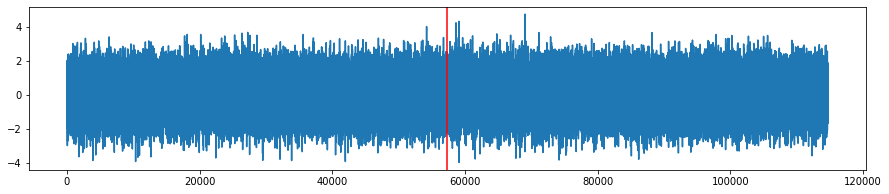

Load :  /home/p00lcy01/TWCC_con/save/kcnn3_elu/model_1.40.h5
Load :  /home/p00lcy01/TWCC_con/save/kcnn3_elu/model_1.00.h5
Load :  /home/p00lcy01/TWCC_con/save/kcnn3_elu/model_0.70.h5


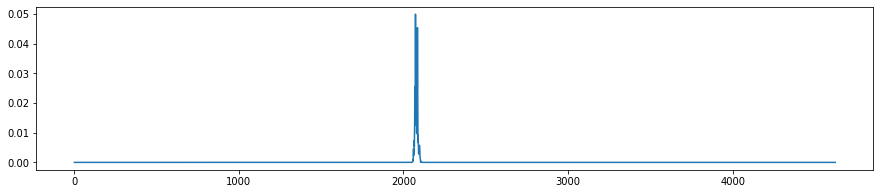

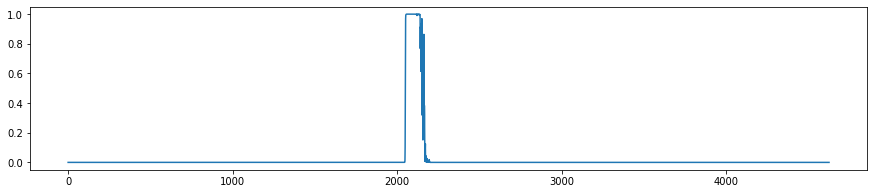

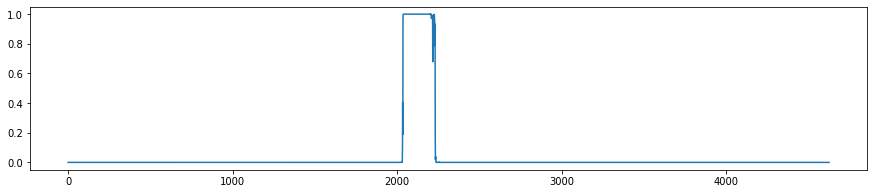

In [257]:
###
###  Testing real data...
###
wopt = {"figsize": (15,3) }

#ROOT_FOLDER = './model'
#ROOT_FOLDER = '/home/p00lcy01/TWCC_con/save/kcnn3_tanh'

TRAIN_A =   [1.8, 1.6, 1.4, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5]
TRAIN_A =   [1.0]
TRAIN_A =   [1.4, 1.0, 0.7]

SKIP = RATE  ##4*RATE   ## to remove the FFT gibbs effect
data = np.load("../real8k/GW150914_H1_w.npy")[SKIP:-SKIP]
plt.figure(**wopt)
plt.plot(data)
plt.axvline(0.5*len(data), color='r')
plt.show()

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    for m in TRAIN_A:

        CKPT = "%s/model_%4.2f.h5" % (ROOT_FOLDER, m )
        try:
            model.load_weights(CKPT)
            print("Load : ", CKPT)
        except: 
            print("Found no : ", CKPT)

        ## predict batch-by-batch    
        DS  = 4   ## every ~200 ms
        dsn = 1 + int( (len(data)-RATE) / DS )    ## of prediction point
        MB  = 512
        prob = np.zeros(dsn)
        for i in range(0, dsn, MB):   ###range(int(np.ceil(dsn/MB))):    # for each MB "mini-batch"

            batch  = min(i+MB, dsn) - i                 ### take care the tail
            xbatch = np.zeros([batch, RATE, 1])

            for b in range(batch):
                s = int((b+i)*DS)
                xbatch[b,:,0] = data[s:s+RATE]

            p_ = model.predict(xbatch, verbose=0)
            #p_ = keras.backend.sigmoid( p_.flatten() )

            prob[i: i + batch] = p_.flatten()

        plt.figure(**wopt)
        plt.plot(prob[11000:-11000])


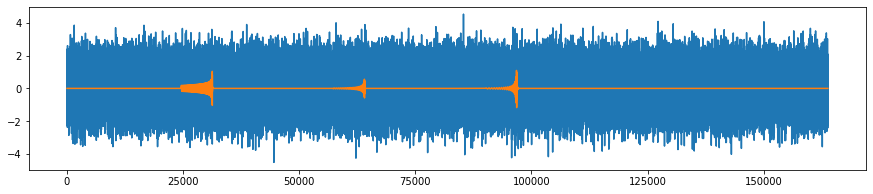

Load :  /home/p00lcy01/TWCC_con/save/kcnn3_tanh_v2/model_1.60.h5
Load :  /home/p00lcy01/TWCC_con/save/kcnn3_tanh_v2/model_1.00.h5
Load :  /home/p00lcy01/TWCC_con/save/kcnn3_tanh_v2/model_0.80.h5
Found no :  /home/p00lcy01/TWCC_con/save/kcnn3_tanh_v2/model_0.60.h5


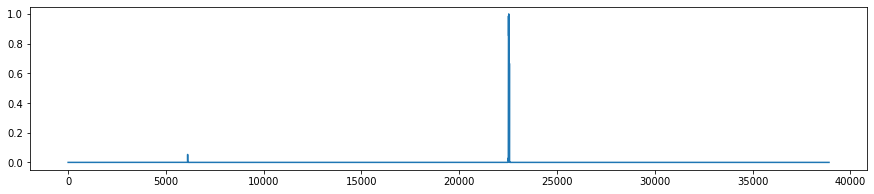

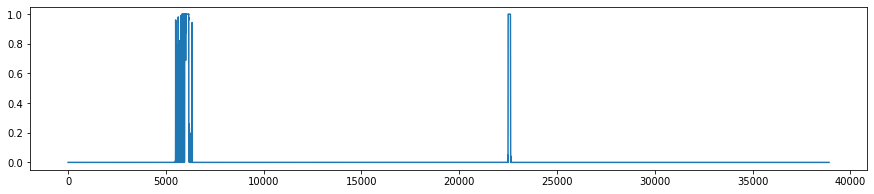

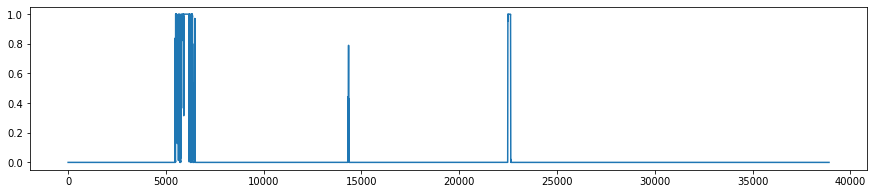

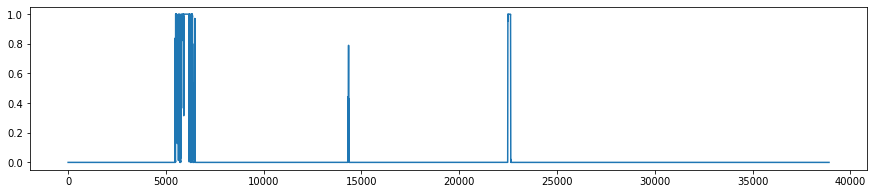

In [260]:
###
###  Testing fake data...
###
wopt = {"figsize": (15,3) }

TRAIN_A =   [1.8, 1.6, 1.4, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5]
TRAIN_A =   [1.6, 1.0, 0.8, 0.6]

def gen3():
    A=[0.9,0.5,1]

    tmp = GWDA.loader.GWInject(H5_FILE)
    inj1 = tmp.f['train_hp'][110]
    inj2 = tmp.f['train_hc'][70]
    inj3 = tmp.f['train_hc'][90]

    data  = np.random.normal(0,1,RATE*20)
    data[3*RATE:4*RATE] += A[0]*inj1
    data[7*RATE:8*RATE] += A[1]*inj2
    data[11*RATE:12*RATE] += A[2]*inj3
    exact = np.zeros(RATE*20)
    exact[3*RATE:4*RATE] += A[0]*inj1
    exact[7*RATE:8*RATE] += A[1]*inj2
    exact[11*RATE:12*RATE] += A[2]*inj3
    return exact, data

def gen1():
    A=[0.9]

    tmp = GWDA.loader.GWInject(H5_FILE)
    inj1 = tmp.f['train_hc'][120]

    data  = np.random.normal(0,1,RATE*3)
    data[RATE:2*RATE] += A[0]*inj1
    exact = np.zeros(RATE*3)
    exact[RATE:2*RATE] += A[0]*inj1
    return exact, data

exact, data = gen3()

plt.figure(**wopt)
plt.plot(data)
plt.plot(exact)
plt.show()

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    #saver = tf.train.Saver(max_to_keep=50)

    for m in TRAIN_A:

        CKPT = "%s/model_%4.2f.h5" % (ROOT_FOLDER, m )
        try:
            model.load_weights(CKPT)
            print("Load : ", CKPT)
        except: 
            print("Found no : ", CKPT)

        ## predict batch-by-batch    
        DS  = 4    ## every ~200 ms
        dsn = 1 + int( (len(data)-RATE) / DS )    ## of prediction point
        MB  = 256
        prob = np.zeros(dsn)
        for i in range(0, dsn, MB):   ###range(int(np.ceil(dsn/MB))):    # for each MB "mini-batch"

            batch  = min(i+MB, dsn) - i                 ### take care the tail
            xbatch = np.zeros([batch, RATE, 1])
            for b in range(batch):
                s = int((b+i)*DS)
                xbatch[b,:,0] = data[s:s+RATE]
            p_ = model.predict(xbatch, verbose=0)
            prob[i: i + batch] = p_.flatten()

        plt.figure(**wopt)
        plt.plot(prob.flatten())

